<a href="https://colab.research.google.com/github/kim-jeonghyun/advanced_detection_segmentation_model/blob/1-inference-with-sam/segment_anything_inference_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything Inference Practice
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1VWB53jTGn50oTTHu3mWkBnDGxpJj8CAA/view?usp=sharing) [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/kim-jeonghyun/advanced_detection_segmentation_model)


Author : [Jeonghyun Kim](kimjeonghyun.jkim@gmail.com)  
Created Date : 2023.10.24  

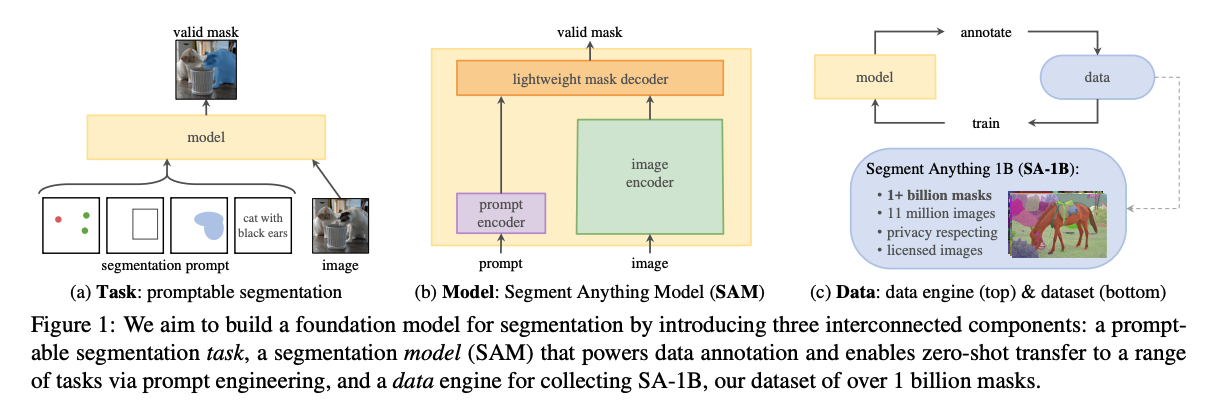

Reference :   
[Segment Anything paper](https://arxiv.org/abs/2304.02643)  
[Segment Anything official repository](https://github.com/facebookresearch/segment-anything/)    
[Segment Anything Study post(kor)](https://kimjeonghyun.notion.site/Segment-Anything-2023-9f5439c042784c1f953006bf84e5e7d9?pvs=4)

In [1]:
import requests
import zipfile
import matplotlib.pyplot as plt
import cv2
import os
import glob
import numpy as np

## Step 0. Check Environment  

The notebook is tested on  
Python 3.10.12   
Ubuntu 22.04.3  
PyTorch 2.1.0+cu121    
NumPy 1.23.5  

버전이 다를 경우 , 의도한 바와 다른 결과가 나올 수 있습니다.

In [17]:
%pwd

'/content'

In [18]:
!python --version

Python 3.10.12


In [19]:
!cat /etc/issue

Ubuntu 22.04.3 LTS \n \l



In [20]:
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

2.1.0+cu121 True


In [21]:
np.__version__

'1.23.5'

## Step 1. Install Segment Anything  

[facebookresearch 공식 깃허브 레포지토리](https://github.com/facebookresearch/segment-anything/)를 활용하여 install하거나 [huggingface의 transformers 라이브러리](https://huggingface.co/docs/transformers/model_doc/sam)를 사용할 수 있는데, 이번 노트북에서는 깃허브를 사용해 인스톨하는 방법을 사용하도록 하겠다.

In [22]:
%pwd

'/content'

In [2]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fyxffflh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fyxffflh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=32129f6b20c2f46386085ecc3547a7a1f02a04273cb33f1199e1e9c7302927a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-yoh9c_8s/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


## Step 2. Download sample Images

샘플 이미지를 다운받아 사용하거나, 본인이 가진 이미지를 업로드하여 사용 가능함

case 1 : 샘플 이미지를 사용하고자 할 때

In [9]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")


In [14]:
download_file(
    'https://www.dropbox.com/s/0etn81u50kfs2ah/input.zip?dl=1',
    'input.zip'
)
unzip('input.zip')

Extracted all


case 2 : 직접 이미지 입력받아서 사용하고자 할 때

In [3]:
from google.colab import files
import os

uploaded = files.upload()
# 특정 파일 타입만 업로드하고 싶은 경우, 예를 들어 이미지 파일만 필터링
for filename in uploaded.keys():
  if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
    print(f"Image file '{filename}' uploaded with length {len(uploaded[filename])} bytes.")
  else:
    print(f"Uploaded file '{filename}' is not an image.")
    # 필요한 경우 비이미지 파일을 삭제
    os.remove(filename)

Saving sample_image.jpg to sample_image.jpg
Image file 'sample_image.jpg' uploaded with length 169378 bytes.


## Step 3. Download the Models

현재 facebook에서 제공하고 있는 pretrained_weights 는 3가지
base 350mb, large 1.2gb, huge 2.5gb이므로 적절하게 선택하여 다운받을 것  
크기가 크므로 매번 다운 받을 필요는 없고 추론시 모델 위치 경로 설정만 잘해주면 됨


In [4]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h.pth

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth -O sam_vit_l.pth

--2024-02-06 09:28:22--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.38, 13.35.7.128, 13.35.7.82, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h.pth’

sam_vit_h.pth       100%[===================>]   2.39G   152MB/s    in 17s     

2024-02-06 09:28:38 (148 MB/s) - ‘sam_vit_h.pth’ saved [2564550879/2564550879]

--2024-02-06 09:28:38--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.38, 13.35.7.128, 13.35.7.82, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’

sam_vit_b.pth     

## Step 4. Inference

SAM 공식 레포에는 모델을 사용하여 이미지에서 객체를 인식하고 세그멘테이션 마스크를 생성하는 클래스가
- SamPredictor : SAM모델을 활용하여 이미지 임베딩을 얻고, 특정 point, 또는 box좌표를 prompt로 받아서 해당 지점이나 영역 내에 있는 객체를 인식하고, 세그멘테이션 마스크를 얻는 작업을 실행할 수 있는 클래스    
- SamAutomaticMaskGenerator : 이미지 전체에 대한 세그멘테이션 마스크를 생성하는 것을 목적으로 하는 클래스 이미지 상의 여러 포인트를 자동으로 선택하고, 각 포인트마다 SamPredictor를 사용해 마스크를 예측한 다음, 낮은 품질의 마스크, 중복된 마스크는 제거하는 작업을 실행함     



In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry

In [6]:
%pwd

'/content'

utility 함수 정의

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        np.dstack((img, m*0.35))
        ax.imshow(np.dstack((img, m*0.35)))

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h.pth")
sam.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

### 4-1. SamPredictor

SamPredictor 클래스를 사용해 이미지 임베딩을 얻어보고, point나 box prompt를 input으로 받아 해당 위치에 있는 객체의 segmentation mask를 얻어보자

In [15]:
filename

'sample_image.jpg'

In [16]:
predictor = SamPredictor(sam)

image_bgr = cv2.imread(filename)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
height, width, channels = image_bgr.shape

# set the image for prediction
predictor.set_image(image_rgb)
# get image_embedding
image_embedding=predictor.get_image_embedding()

In [18]:
image_embedding.size()

torch.Size([1, 256, 64, 64])

[1, 256, 64, 64] 사이즈의 이미지 임베딩을 얻을 수 있다.

특정 포인트를 prompt로 하여 객체 인식을 할 수 있다.  
내가 원하는 객체의 포인트 좌표를 정확히 얻기는 어렵기 때문에, 우선 이미지의 중앙을 point prompt로 잡겠다.  

In [38]:
input_point = np.array([[width//2, height//2]])
input_label = np.array([1]) # 이곳의 객체를 얻겠다는 positive point는 1, 반대는 0

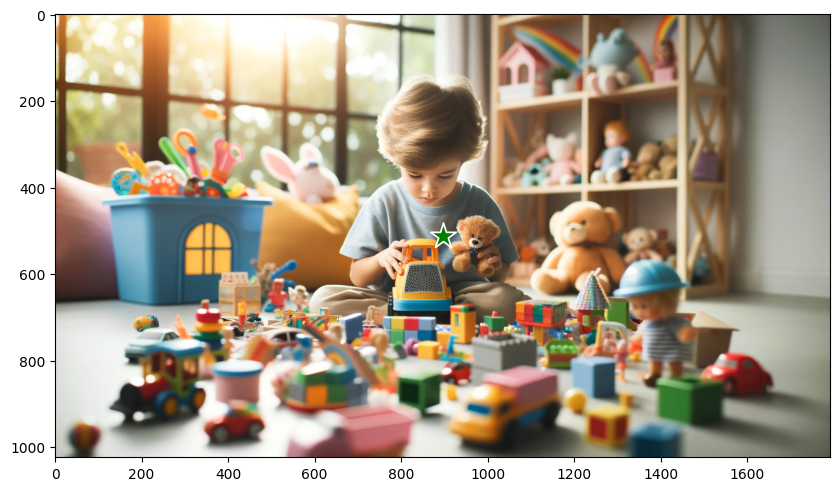

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [40]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

SamPredictor는 3개의 mask를 예측해주는데, 보다 좁은 범위를 하나의 객체로 하는 mask에서 넓은 범위를 하나의 객체 mask로 인식하는 순서대로 나열되어있다.

In [41]:
masks.shape  # (number_of_masks) x H x W


(3, 1024, 1792)

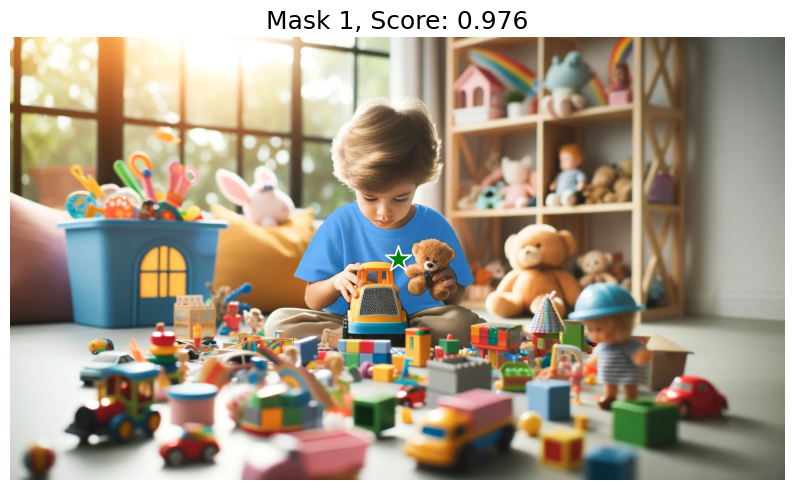

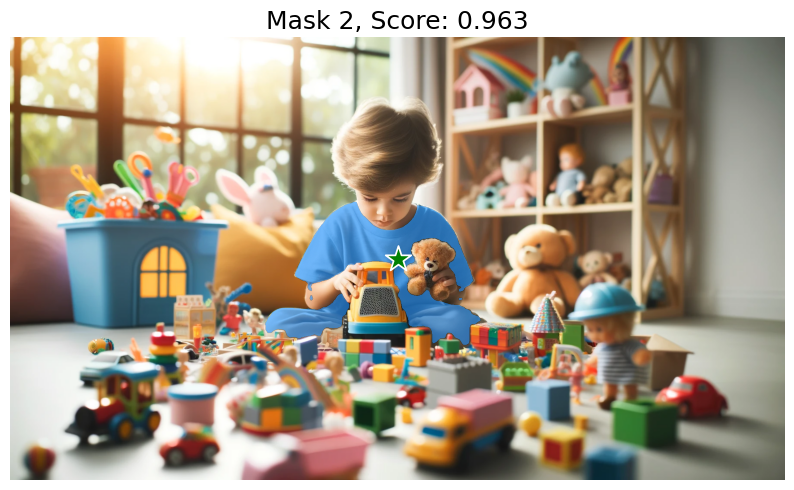

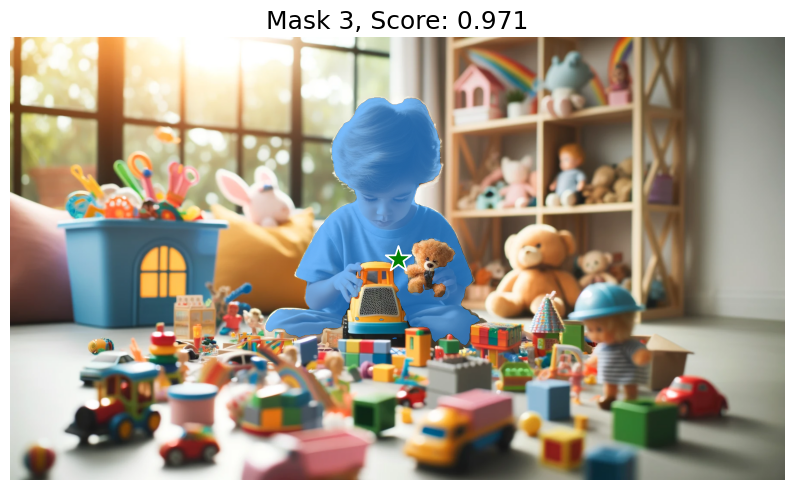

In [42]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image_rgb)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


이미지 전체에서 segmentation 마스크를 예측하는 것은 SamAutomaticMaskGenerator 클래스의 generate 메소드를 사용한다.

In [43]:
os.makedirs('output', exist_ok=True)

In [ ]:
image_path = f"./{filename}"
image_name = image_path.split(os.path.sep)[-1]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)
plt.figure(figsize=(12, 9))
plt.imshow(image)
show_anns(masks)
plt.axis('on')
plt.savefig(os.path.join('output', image_name), bbox_inches='tight')

masks 안에는 인식한 객체들에 대한 정보가 리스트로 들어있다.

In [ ]:
len(masks)

In [46]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 36659,
 'bbox': [0, 361, 144, 301],
 'predicted_iou': 1.0160531997680664,
 'point_coords': [[140.0, 624.0]],
 'stability_score': 0.9928783178329468,
 'crop_box': [0, 0, 1792, 1024]}